<a href="https://colab.research.google.com/github/sunnyineverywhere/ML_KINML/blob/main/House_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Evaluating House Prices (via House Prices dataset, Ames, Iowa)

---

## 🎮 TEAM KINML
| Hyunjung Park | Yeongeun Kim | Seon UI Lee | Seungyoun Lee | Yunju Jang |
| :---: | :---: | :---: | :---: | :---: |
| Linear Regression | lightGBM | Random Forest | lightGBM | XGBoost |

<br />
  
## 👏 Project Info
> In this project, members predict house prices with Machine Learning Models. We tested Linaer Regression, LightGBM, Random Forest, XGBoost.   

> By measuring propagation with mae & rmae, we found that lightGBM is the best model for our project.  

> This project is uploaded in [Kaggle Competition](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques) and we ranked 1037th.


# Model & Scores
---

<br />

## 1. Import Data

In [15]:
import numpy as np
import pandas as pd

from scipy import stats
from scipy.stats import norm, skew #for some statistics

!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=15nk00lZXpCiOPXAtpkBoT7RdmRyCCq_U' -O test.csv
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id=1uDTPwWIAays7N7zY4113_Mygr5zJ2jWC' -O train.csv

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

--2022-12-08 00:49:32--  https://docs.google.com/uc?export=download&id=15nk00lZXpCiOPXAtpkBoT7RdmRyCCq_U
Resolving docs.google.com (docs.google.com)... 173.194.74.113, 173.194.74.138, 173.194.74.139, ...
Connecting to docs.google.com (docs.google.com)|173.194.74.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-08-80-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vfb5lnlcloovv2e8456i9g3tupjakhbq/1670460525000/14827738442420886269/*/15nk00lZXpCiOPXAtpkBoT7RdmRyCCq_U?e=download&uuid=c7885129-ee3f-416a-be2b-b7252fafbd8c [following]
--2022-12-08 00:49:33--  https://doc-08-80-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vfb5lnlcloovv2e8456i9g3tupjakhbq/1670460525000/14827738442420886269/*/15nk00lZXpCiOPXAtpkBoT7RdmRyCCq_U?e=download&uuid=c7885129-ee3f-416a-be2b-b7252fafbd8c
Resolving doc-08-80-docs.googleusercontent.com (doc-08-80-docs.googleusercontent.com)... 142.250.152.132, 2607:f8b0

### 1-1. Remove Outliers

In [16]:
#아웃라이어 제거
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

## 2. Get the fitted parameters using normalization function

In [17]:
# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( 'mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))

# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
train["SalePrice"] = np.log1p(train["SalePrice"])

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print( 'mu = {:.2f} and sigma = {:.2f}'.format(mu, sigma))

mu = 180932.92 and sigma = 79467.79
mu = 12.02 and sigma = 0.40


In [18]:
import matplotlib.pyplot as plt
# vNd = np.random.normal(50, 10, 1000)
# plt.hist(vNd, 100)
# plt.show()

## 3. Data PreProcessing
---

### 3-1. Merging data

In [19]:
#데이터 합침
ntrain = train.shape[0]
ntrain = int(ntrain * 0.8)
#ntest = train.shape[ntrain:]
y_train = train[:ntrain].SalePrice.values
y_test = train[ntrain:].SalePrice.values

#all_data = pd.concat((train, test)).reset_index(drop=True)
all_data = train
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (1458, 80)


### 3-2. Remove Null values

In [20]:
#NULL 값 처리
all_data["PoolQC"] = all_data["PoolQC"].fillna("None")
all_data["MiscFeature"] = all_data["MiscFeature"].fillna("None")
all_data["Alley"] = all_data["Alley"].fillna("None")
all_data["Fence"] = all_data["Fence"].fillna("None")
all_data["FireplaceQu"] = all_data["FireplaceQu"].fillna("None")
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
  all_data[col] = all_data[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
  all_data[col] = all_data[col].fillna(0)

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
  all_data[col] = all_data[col].fillna(0)

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
  all_data[col] = all_data[col].fillna('None')

all_data["MasVnrType"] = all_data["MasVnrType"].fillna("None")
all_data["MasVnrArea"] = all_data["MasVnrArea"].fillna(0)

all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

all_data = all_data.drop(['Utilities'], axis=1)

all_data["Functional"] = all_data["Functional"].fillna("Typ")

all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])

all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])

all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])

all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

### 3-3. Check Remaining Null Data

In [21]:
#Check remaining missing values if any 
all_data_na = (all_data.isnull().sum() / len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio' :all_data_na})
missing_data.head()

,Missing Ratio


### 3-4. Data Processing
- LabelEncorder
- Check the **skew** of all numerical features

In [22]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)

#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

In [23]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

# process columns, apply LabelEncoder to categorical features
for c in cols:
  lbl = LabelEncoder() 
  lbl.fit(list(all_data[c].values)) 
  all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

Shape all_data: (1458, 79)


In [24]:
from scipy.stats import skew
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,24.434913
PoolArea,15.932532
LotArea,12.560986
3SsnPorch,10.286510
LowQualFinSF,8.995688
LandSlope,4.805032
KitchenAbvGr,4.480268
BsmtFinSF2,4.247550
ScreenPorch,4.114690
BsmtHalfBath,4.095895


In [25]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
  #all_data[feat] += 1
  all_data[feat] = boxcox1p(all_data[feat], lam)

There are 59 skewed numerical features to Box Cox transform


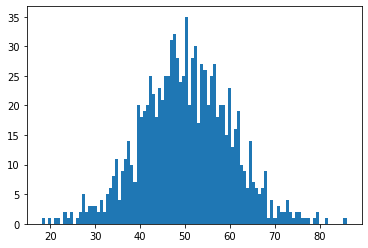

In [26]:
vNd = np.random.normal(50, 10, 1000)
plt.hist(vNd, 100)
plt.show()

### 3-5. Split Data into train & test 

In [27]:
all_data = pd.get_dummies(all_data)

train = all_data[:ntrain]
test = all_data[ntrain:]


## 4. LightGBM Model
---

In [28]:
from sklearn.model_selection import KFold, cross_val_score, train_test_split
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

In [29]:
n_folds = 5

def rmsle_cv(model):
  kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
  rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
  return(rmse)

In [30]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})" .format(score.mean(), score.std()))

LGBM score: 0.1209 (0.0064)


In [31]:
from sklearn.model_selection import GridSearchCV
param = {
    'max_depth':[2,3,4],
    'n_estimators':range(550,700,50),
    'colsample_bytree':[0.5,0.7,1],
    'colsample_bylevel':[0.5,0.7,1],
}

model_lgb2 = lgb.LGBMRegressor(objective='regression')
grid_search = GridSearchCV(estimator=model_lgb2, param_grid=param, cv=3, refit = True)

grid_search.fit(train, y_train)
#grid_search.cv_results_["params"]
grid_search.cv_results_["mean_test_score"]

print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'colsample_bylevel': 0.5, 'colsample_bytree': 0.7, 'max_depth': 2, 'n_estimators': 550}
LGBMRegressor(colsample_bylevel=0.5, colsample_bytree=0.7, max_depth=2,
              n_estimators=550, objective='regression')


In [32]:
model_lgb2 = lgb.LGBMRegressor(objective='regression', colsample_bylevel = 0.5, colsample_bytree = 0.7, max_depth = 2, n_estimators = 550)
model_lgb2.fit(train, y_train)
lgb_train_pred2 = model_lgb2.predict(train)
lgb_pred2 = model_lgb2.predict(test)

In [33]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
print('train mae score: ', mean_absolute_error(y_train, lgb_train_pred2))
print('train rmse score: ', math.sqrt(mean_squared_error(y_train, lgb_train_pred2)))
print('val mae score:', mean_absolute_error(y_test, lgb_pred2))
print('val rmse score: ', math.sqrt(mean_squared_error(y_test, lgb_pred2)))

train mae score:  0.05091395403926436
train rmse score:  0.0737261644881046
val mae score: 0.08453178459719654
val rmse score:  0.11953698936962039


In [34]:
def rmsle(y, y_pred):
  return np.sqrt(mean_squared_error(y, y_pred))

In [35]:
#y_train = np.expm1(y_train)
#print(y_train)

In [36]:
#y_train = np.expm1(y_train)
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_train_pred = np.expm1(model_lgb.predict(train))
lgb_pred = np.expm1(model_lgb.predict(test.values))
#y의 값에 로그변환이 되어있기 때문에 expm1 해주면 원래 값으로 변환 가능
#실제 test값을 넣을 때는 expm1을 취해야함
#lgb_pred = model_lgb.predict(test)
print(rmsle(y_train, lgb_train_pred))

195346.4821314895


In [37]:
# print(np.round(lgb_pred,3))

In [38]:
# print(y_test)

In [39]:
print(ntrain)

1166


### 4-1. LightGBM TEST

In [40]:
#y_test
print(rmsle(y_test, lgb_pred))

195227.20701770484


### 4-2. LightGBM MAE. & RMSE SCORE

In [41]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
print('train mae score: ', mean_absolute_error(y_train, lgb_train_pred))
print('train rmse score: ', math.sqrt(mean_squared_error(y_train, lgb_train_pred)))
#print('val mae score:', mean_absolute_error(y_val, pred_val))

train mae score:  179833.58257183974
train rmse score:  195346.4821314895


### 4-3. LightGBM MAE. & RMSE SCORE for test values

In [42]:
print('val mae score:', mean_absolute_error(y_test, lgb_pred))
print('val rmse score: ', math.sqrt(mean_squared_error(y_test, lgb_pred)))

val mae score: 180914.98261643492
val rmse score:  195227.20701770484


### 4-4. LightGBM Prediction Graph

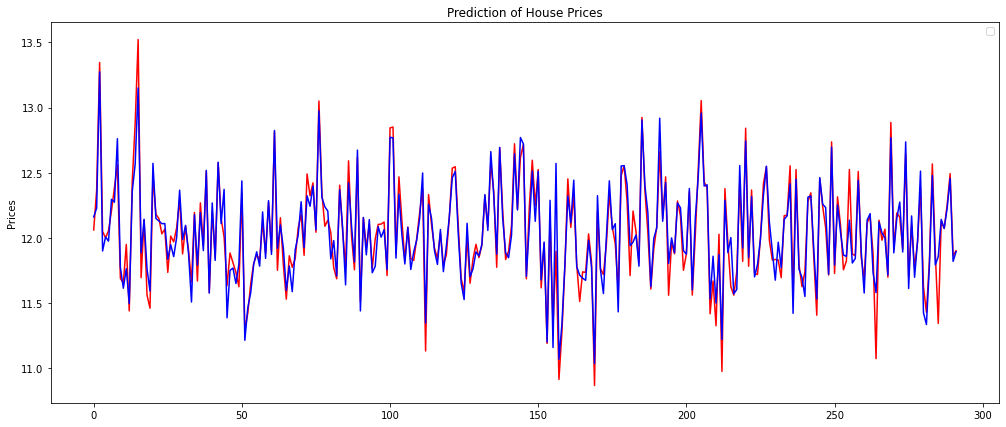

In [43]:

plt.figure(figsize=(17,7))
plt.plot(y_test, color='red')
plt.plot(lgb_pred2, color='blue')
plt.title('Prediction of House Prices')
plt.ylabel('Prices')
plt.legend()

## 5. XGBoost Model
---

### 5-1. GridSearchCV
> find best parameters

In [44]:
from sklearn.model_selection import GridSearchCV
import xgboost as xgb

param = {
    'max_depth':[2,3,4],
    'n_estimators':range(550,700,50),
    'colsample_bytree':[0.5,0.7,1],
    'colsample_bylevel':[0.5,0.7,1],
}
model = xgb.XGBRegressor(objective='reg:squarederror')
grid_search = GridSearchCV(estimator=model, param_grid=param, cv=3, refit = True)

grid_search.fit(train, y_train)
#grid_search.cv_results_["params"]
grid_search.cv_results_["mean_test_score"]

print(grid_search.best_params_)
print(grid_search.best_estimator_)

{'colsample_bylevel': 0.5, 'colsample_bytree': 0.5, 'max_depth': 2, 'n_estimators': 650}
XGBRegressor(colsample_bylevel=0.5, colsample_bytree=0.5, max_depth=2,
             n_estimators=650, objective='reg:squarederror')


### 5-2. XGBoost Model with best parameters

In [45]:
model = xgb.XGBRegressor(colsample_bylevel=0.5, colsample_bytree=0.5, max_depth=2, n_estimators=650,
             objective='reg:squarederror')
model.fit(train, y_train)
predictions = model.predict(test)
predictions

array([12.147383 , 12.16808  , 13.113055 , 11.854015 , 12.008049 ,
       11.957086 , 12.309932 , 12.273519 , 12.681962 , 11.782267 ,
       11.625037 , 11.803302 , 11.4922285, 12.373443 , 12.590379 ,
       13.293007 , 11.911557 , 12.23759  , 11.751147 , 11.576146 ,
       12.587044 , 12.125126 , 12.1815815, 12.082633 , 12.1058445,
       11.799816 , 12.00401  , 11.885467 , 11.949941 , 12.291126 ,
       11.969243 , 12.075846 , 11.84305  , 11.506166 , 12.139882 ,
       11.786054 , 12.212862 , 11.891338 , 12.568632 , 11.597685 ,
       12.231603 , 11.855016 , 12.554747 , 12.1388235, 12.439378 ,
       11.40311  , 11.778711 , 11.767895 , 11.623243 , 11.764637 ,
       12.387125 , 11.400589 , 11.472768 , 11.608833 , 11.771163 ,
       11.938047 , 11.810431 , 12.224666 , 11.85708  , 12.247274 ,
       11.883835 , 12.836892 , 11.845358 , 12.127758 , 11.900436 ,
       11.520794 , 11.79585  , 11.644604 , 11.882189 , 12.012972 ,
       12.244373 , 11.919669 , 12.317583 , 12.18953  , 12.3986

### 5-3. XGBoost MAE & RMSE score

In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
pred_train = grid_search.predict(train)
pred_test = grid_search.predict(test)

#print('train acc score: ',accuracy = accuracy_score(y_train, pred_train))
#print('val acc score: ',accuracy = accuracy_score(y_val, pred_val))

print('train mae score: ', mean_absolute_error(y_train, pred_train))
print('val mae score:', mean_absolute_error(y_test,pred_test))

print('train rmse score: ', math.sqrt(mean_squared_error(y_train, pred_train)))
print('val rmse score: ', math.sqrt(mean_squared_error(y_test, pred_test)))

train mae score:  0.04398165402857415
val mae score: 0.0851581830816306
train rmse score:  0.061021126356539536
val rmse score:  0.12018341305298463


### 5-4. XGBoost Prediction Graph  
// TODO: 확인 필요

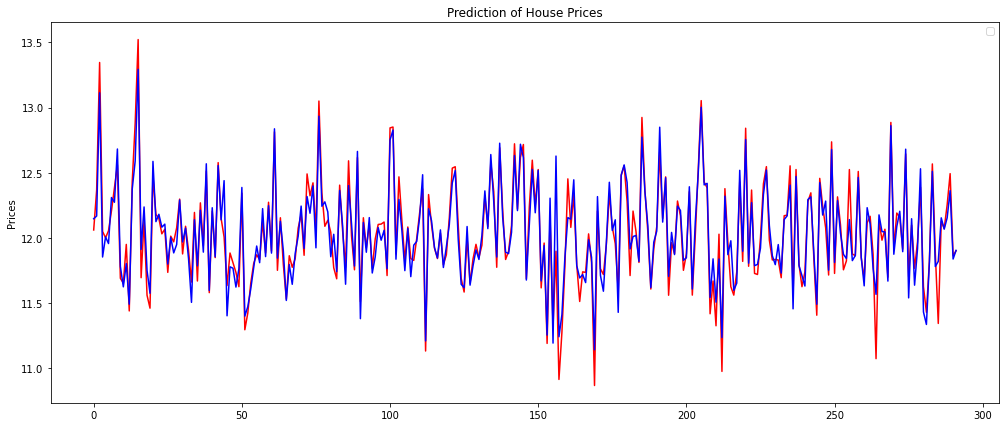

In [47]:
plt.figure(figsize=(17,7))
plt.plot(y_test, color='red')
plt.plot(pred_test, color='blue')
plt.title('Prediction of House Prices')
plt.ylabel('Prices')
plt.legend()

## 6. Random Forest
---

### 6-1. Random Forest Model

In [48]:
# Fit Random Forest on Training Set
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
regressor = RandomForestRegressor(n_estimators=300, random_state=0)
regressor.fit(train, y_train)

0.9837518574967853

### 6-2. Random Forest MAE & RMSE score

In [50]:
rf_pred_train = regressor.predict(train)
rf_pred_test = regressor.predict(test)

print('train mae score: ', mean_absolute_error(y_train, rf_pred_train))
print('val mae score:', mean_absolute_error(y_test,rf_pred_test))

print('train rmse score: ', math.sqrt(mean_squared_error(y_train, rf_pred_train)))
print('val rmse score: ', math.sqrt(mean_squared_error(y_test, rf_pred_test)))

train mae score:  0.03530281255092575
val mae score: 0.09650576139789821
train rmse score:  0.051196416098820356
val rmse score:  0.1394859510047907


### 6-3. Random Forest Prediction Graph

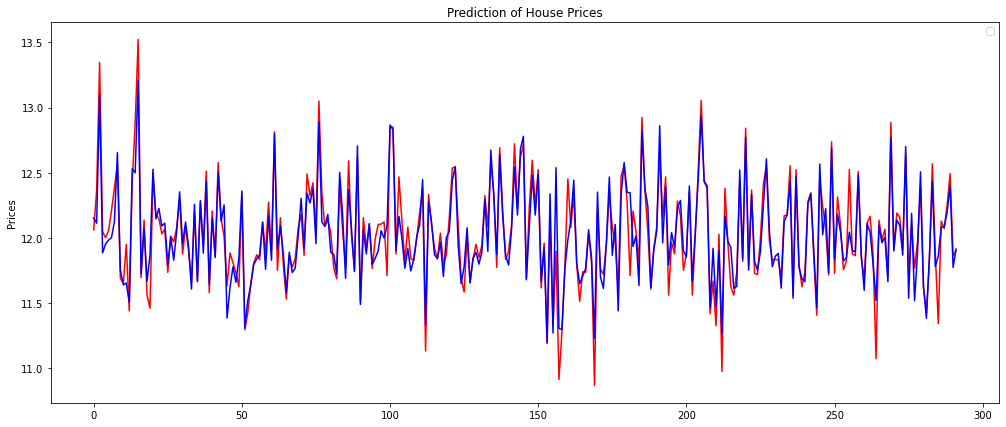

In [51]:
plt.figure(figsize=(17,7))
plt.plot(y_test, color='red')
plt.plot(rf_pred_test, color='blue')
plt.title('Prediction of House Prices')
plt.ylabel('Prices')
plt.legend()

## 7. Linear Regression

In [49]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

# print best rmse and return best_estimator
def get_best_estimator(model, params):
    grid_model = GridSearchCV(model, param_grid=params, scoring="neg_mean_squared_error", cv=5)
    grid_model.fit(train, y_train)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print('{0}, param:{1}, rmse:{2}'.format(model.__class__.__name__, grid_model.best_params_,\
                                            np.round(rmse, 4)))
    return grid_model.best_estimator_

ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 15]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.1, 0.3, 0.5, 1, 5, 10]}
elastic_params = {'alpha':[0.05, 0.1, 0.5, 1, 3, 5, 8]}

ridge_reg = Ridge()
lasso_reg = Lasso() 
elastic_reg = ElasticNet(l1_ratio=0.7)

lasso_be = get_best_estimator(lasso_reg, lasso_params)
ridge_be = get_best_estimator(ridge_reg, ridge_params)
elastic_be = get_best_estimator(elastic_reg, elastic_params)

Lasso, param:{'alpha': 0.001}, rmse:0.1193
Ridge, param:{'alpha': 8}, rmse:0.1199
ElasticNet, param:{'alpha': 0.05}, rmse:0.1903
